In [1]:
import pImpactR as impact
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from copy import deepcopy as copy
from scipy.optimize import minimize
import shutil 
import pickle
rectangular_ = 1
elliptic_ = 2

In [2]:
NL_t = 0.4
emitGeomRMS = 3.3e-6
npt = 50000
print('npt=',npt)
nturn = 2000

npt= 50000


In [3]:
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

In [4]:
full_data = pickle.load(open('pLossData_iota_v8_4_variousSextSettings.pickle','rb'))
# deco = 'iota_v8_4_SextOff_NLon_thermal'
# print(len(full_data[deco]['pLost'])/50000)
# deco = 'iota_v8_4_SextOn_NLon_thermal'
# print(len(full_data[deco]['pLost'])/50000)

In [5]:
full_data.keys()

dict_keys(['iota_v8_4_SextOff_NLon_thermal', 'iota_v8_4_SextOn_NLon_thermal', 'iota_v8_4_SextGoodDA_NLon_thermal', 'iota_v8_4_SextOff_NLon_exponential', 'iota_v8_4_SextOn_NLon_exponential', 'iota_v8_4_SextGoodDA_NLon_exponential'])

# read Aperture

In [6]:
aperture = np.loadtxt('pipeinfo.in')

In [7]:
np.min(aperture[:,1]),np.min(aperture[:,2])

(0.004, 0.0055000000000000005)

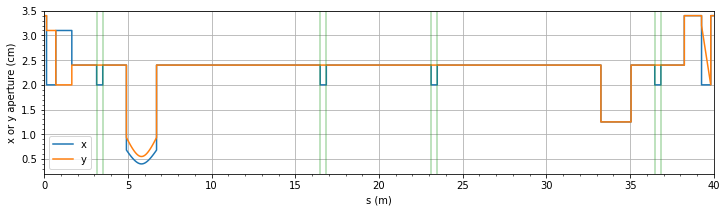

In [8]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.minorticks_on()
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [9]:
ap0_x,ap0_y = 0.00680513, 0.00935705
ap1_x,ap1_y = 4.00000000e-03, 5.50000000e-03
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

In [10]:
L=aperture[-1,0]
L

39.968229720000004

In [11]:
beam,lattice = impact.readInputFile('test_iota_v8_4_SextOff_NLon.in')
L=0
for item in lattice:
    if item.type == 'nonlinear_insert':
        loc_NL =L
    if 'length' in item:
        L=L+item.length
print()
print('loc_NL = ',loc_NL)

reading ImpactZ input file (test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done

loc_NL =  4.91151914291883


#  Thermal beam

### SextOff

In [12]:
deco = 'iota_v8_4_SextOff_NLon_thermal'
data = full_data[deco]

In [13]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.9322492e-07, 4.077177e-07, 0.0591737859426, 0.0688034456575)

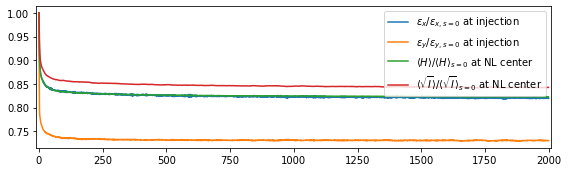

In [14]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

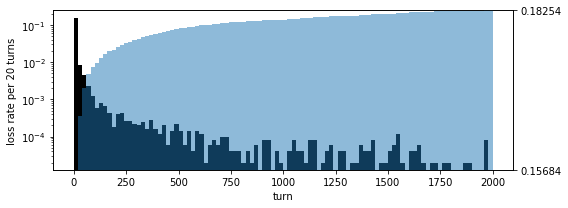

In [15]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

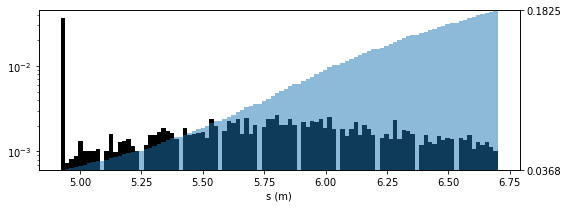

In [16]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [17]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [18]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [19]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData0'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [20]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [21]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

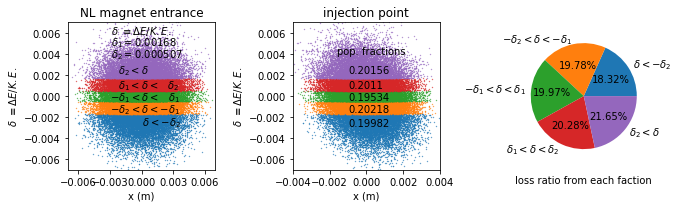

In [22]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,3,figsize=(9.5,3), gridspec_kw={'width_ratios': [1,1,0.9]})
# plt.subplot(1,3,1)
k=0
for i in range(5):
    axs[k].scatter(data['pData0'][pDataIndex[i],0],data['pData0'][pDataIndex[i],5]/2.5e6,s=0.1)
axs[k].set_xlim(-0.007,0.007)
axs[k].set_xticks([-0.006,-0.003,0,0.003,0.006])
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0029,  0.0059,r'$\delta\,\,\equiv \Delta E/K.E.$');
axs[k].text(-0.0029,  0.0048,r'$\delta_1=0.00168 $');
axs[k].text(-0.0029,  0.0037,r'$\delta_2=0.000507$');
axs[k].text(-0.003, .00219 ,r'$\,\,\,\,\,\delta_2 < \delta$');
axs[k].text(-0.003, .000752,r'$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$');
axs[k].text(-0.003,-.000387,r'$-\delta_1 < \delta < \,\,\,\,\,\delta_1$');
axs[k].text(-0.003,-.001548,r'$-\delta_2 < \delta < -\delta_1$');
axs[k].text(-0.003,-.00283 ,r'$\qquad\quad\,\, \delta < -\delta_2$');
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('NL magnet entrance')

# plt.subplot(1,3,2)
k=1
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=2
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [23]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

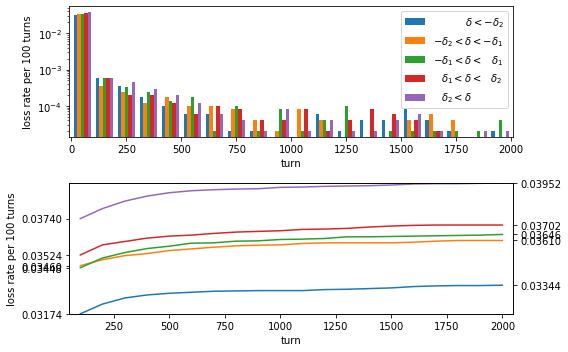

In [24]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [25]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

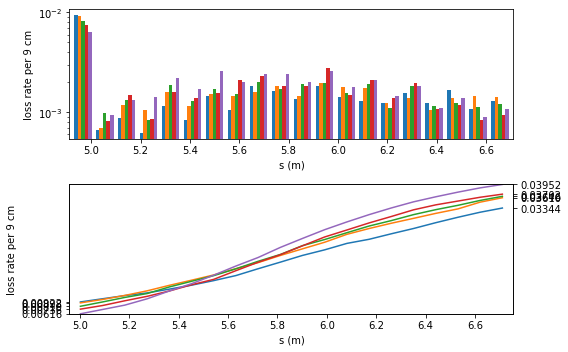

In [26]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

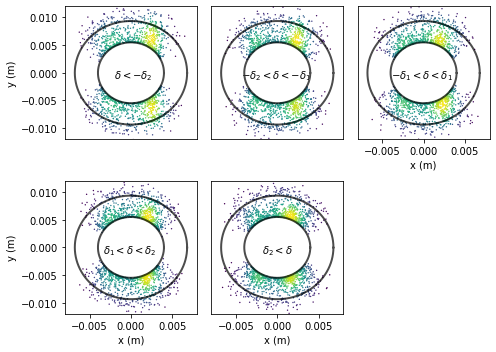

In [27]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [28]:
data['Twiss1']

(0.49524020293287413,
 0.16669260330749974,
 2.645169074698375e-06,
 2.047576820369176,
 0.4621109662791848,
 5.5814862683766e-06,
 1338.7005768170793,
 2.3611888931473417,
 0.0051337593474649855)

In [29]:
data['Twiss0']

(1.5041298620907557,
 1.093733875298495,
 2.606229433987202e-06,
 3.256043858372408,
 2.3734884356496115,
 5.58030380890158e-06,
 198.6124795972191,
 0.004643657935692338,
 0.005007939228735678)

### SextOn

In [30]:
deco = 'iota_v8_4_SextOn_NLon_thermal'
data = full_data[deco]

In [31]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.93411e-07, 4.078428e-07, 0.0591737834217, 0.0688036982193)

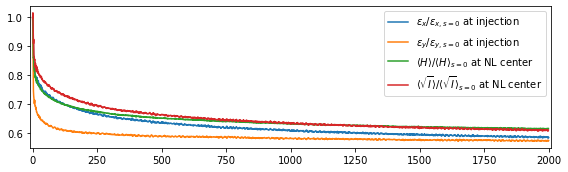

In [32]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

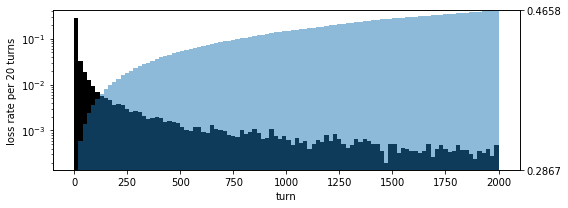

In [33]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

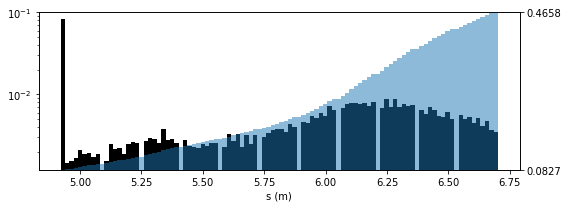

In [34]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [35]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [36]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [37]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData0'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [38]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [39]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

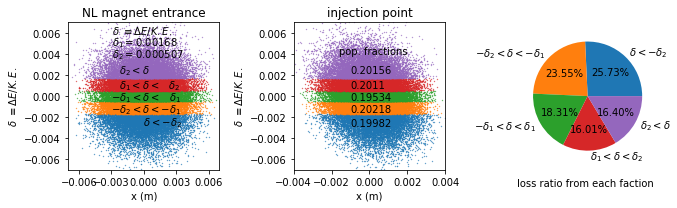

In [40]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,3,figsize=(9.5,3), gridspec_kw={'width_ratios': [1,1,0.9]})
# plt.subplot(1,3,1)
k=0
for i in range(5):
    axs[k].scatter(data['pData0'][pDataIndex[i],0],data['pData0'][pDataIndex[i],5]/2.5e6,s=0.1)
axs[k].set_xlim(-0.007,0.007)
axs[k].set_xticks([-0.006,-0.003,0,0.003,0.006])
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0029,  0.0059,r'$\delta\,\,\equiv \Delta E/K.E.$');
axs[k].text(-0.0029,  0.0048,r'$\delta_1=0.00168 $');
axs[k].text(-0.0029,  0.0037,r'$\delta_2=0.000507$');
axs[k].text(-0.003, .00219 ,r'$\,\,\,\,\,\delta_2 < \delta$');
axs[k].text(-0.003, .000752,r'$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$');
axs[k].text(-0.003,-.000387,r'$-\delta_1 < \delta < \,\,\,\,\,\delta_1$');
axs[k].text(-0.003,-.001548,r'$-\delta_2 < \delta < -\delta_1$');
axs[k].text(-0.003,-.00283 ,r'$\qquad\quad\,\, \delta < -\delta_2$');
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('NL magnet entrance')

# plt.subplot(1,3,2)
k=1
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=2
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [41]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

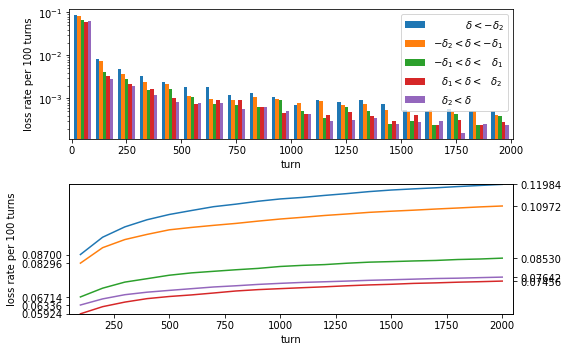

In [42]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [43]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

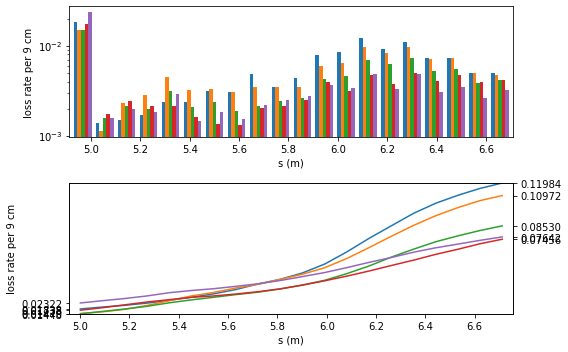

In [44]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

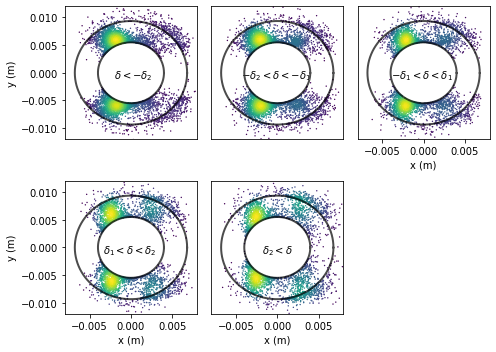

In [45]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [46]:
data['Twiss1']

(0.495678691149796,
 0.16728366256925262,
 2.647716355508742e-06,
 2.0469239484475756,
 0.46152342234027177,
 5.583198895890598e-06,
 1338.7099482333906,
 2.3612086895881452,
 0.005133722294258112)

In [47]:
data['Twiss0']

(1.5041298620907557,
 1.093733875298495,
 2.606229433987202e-06,
 3.256043858372408,
 2.3734884356496115,
 5.58030380890158e-06,
 198.6124795972191,
 0.004643657935692338,
 0.005007939228735678)

### GoodDA

In [48]:
deco = 'iota_v8_4_SextGoodDA_NLon_thermal'
data = full_data[deco]

In [49]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.93411e-07, 4.078428e-07, 0.0591737834217, 0.0688036982193)

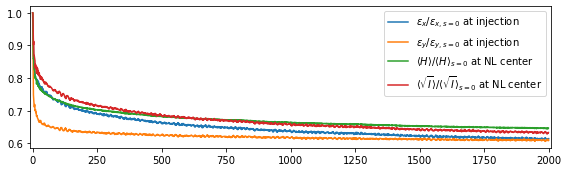

In [50]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

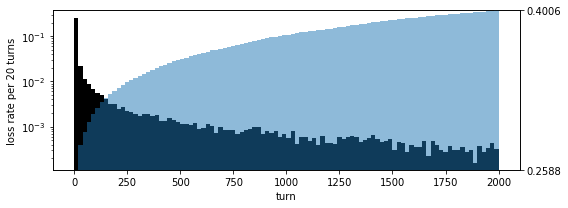

In [51]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

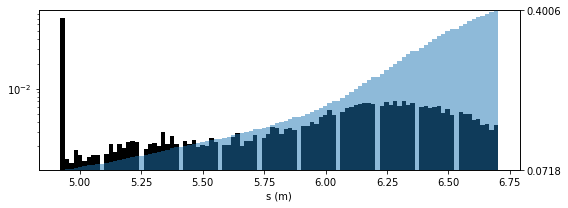

In [52]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [53]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [54]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [55]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData0'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [56]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [57]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

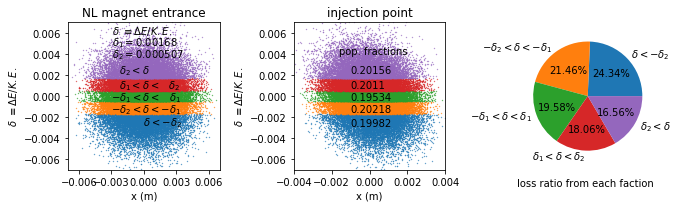

In [58]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,3,figsize=(9.5,3), gridspec_kw={'width_ratios': [1,1,0.9]})
# plt.subplot(1,3,1)
k=0
for i in range(5):
    axs[k].scatter(data['pData0'][pDataIndex[i],0],data['pData0'][pDataIndex[i],5]/2.5e6,s=0.1)
axs[k].set_xlim(-0.007,0.007)
axs[k].set_xticks([-0.006,-0.003,0,0.003,0.006])
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0029,  0.0059,r'$\delta\,\,\equiv \Delta E/K.E.$');
axs[k].text(-0.0029,  0.0048,r'$\delta_1=0.00168 $');
axs[k].text(-0.0029,  0.0037,r'$\delta_2=0.000507$');
axs[k].text(-0.003, .00219 ,r'$\,\,\,\,\,\delta_2 < \delta$');
axs[k].text(-0.003, .000752,r'$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$');
axs[k].text(-0.003,-.000387,r'$-\delta_1 < \delta < \,\,\,\,\,\delta_1$');
axs[k].text(-0.003,-.001548,r'$-\delta_2 < \delta < -\delta_1$');
axs[k].text(-0.003,-.00283 ,r'$\qquad\quad\,\, \delta < -\delta_2$');
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('NL magnet entrance')

# plt.subplot(1,3,2)
k=1
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=2
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [59]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

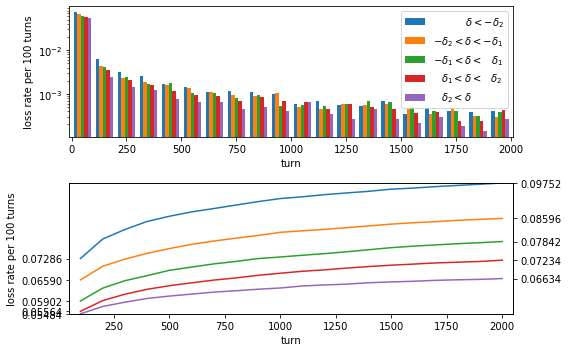

In [60]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [61]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

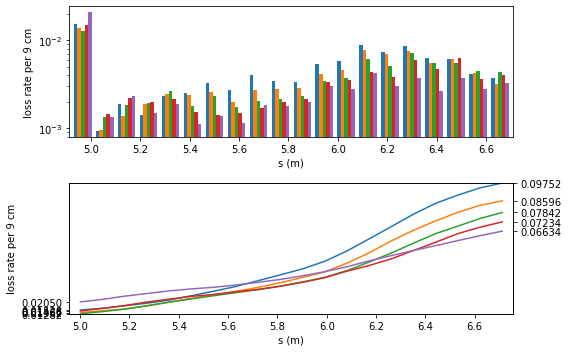

In [62]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

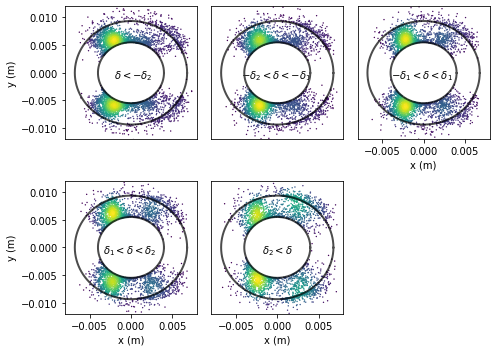

In [63]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [64]:
data['Twiss1']

(0.495678691149796,
 0.16728366256925262,
 2.647716355508742e-06,
 2.0469239484475756,
 0.46152342234027177,
 5.583198895890598e-06,
 1338.7099482333906,
 2.3612086895881452,
 0.005133722294258112)

In [65]:
data['Twiss0']

(1.5041298620907557,
 1.093733875298495,
 2.606229433987202e-06,
 3.256043858372408,
 2.3734884356496115,
 5.58030380890158e-06,
 198.6124795972191,
 0.004643657935692338,
 0.005007939228735678)

#  Exponential beam

### SextOff

In [66]:
deco = 'iota_v8_4_SextOff_NLon_exponential'
data = full_data[deco]

In [67]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.9037692e-07, 4.0355608e-07, 0.0774647768163, 0.072459755029)

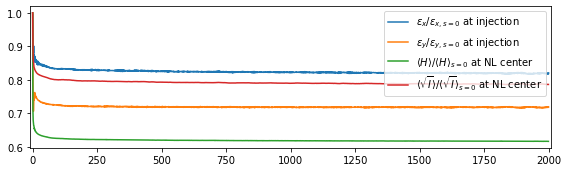

In [68]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

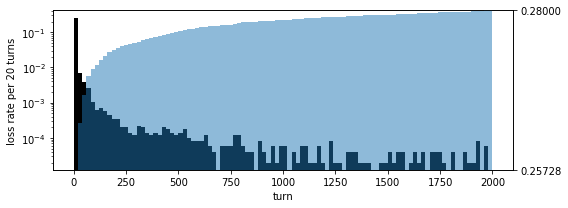

In [69]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

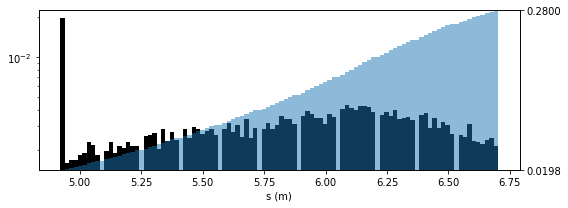

In [70]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [71]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [72]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [73]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData1'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [74]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [75]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

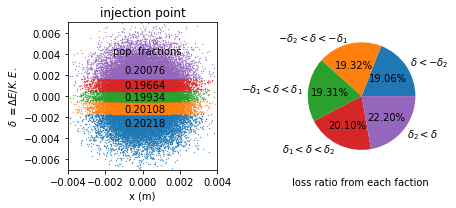

In [76]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,2,figsize=(6.4,3), gridspec_kw={'width_ratios': [1,0.9]})
k=0
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=1
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [77]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

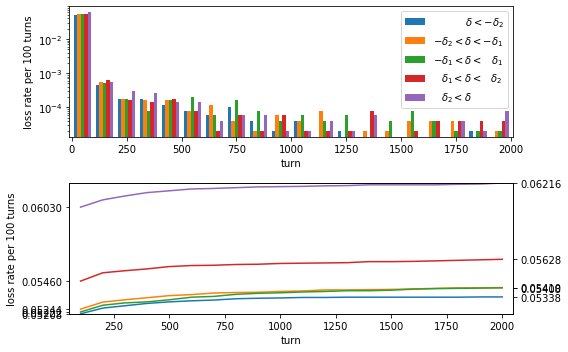

In [78]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [79]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

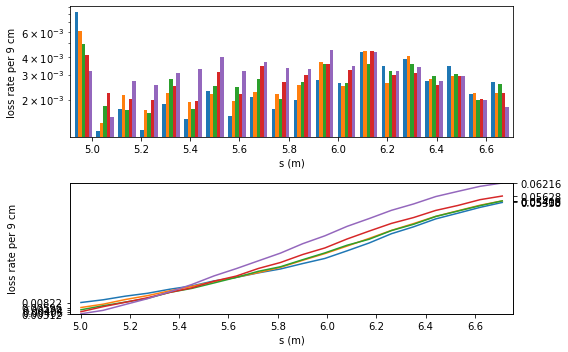

In [80]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

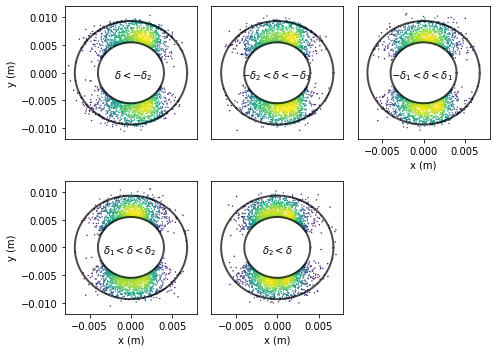

In [81]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [82]:
data['Twiss1']

(0.49414569983363116,
 0.1683315764183921,
 2.6061810960710044e-06,
 2.066065487818308,
 0.46639366775329355,
 5.524515268345755e-06,
 199.47975220151977,
 0.005106741403843367,
 0.005010376903345726)

### SextOn

In [83]:
deco = 'iota_v8_4_SextOn_NLon_exponential'
data = full_data[deco]

In [84]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.9037692e-07, 4.0355608e-07, 0.0774740727948, 0.0724770814064)

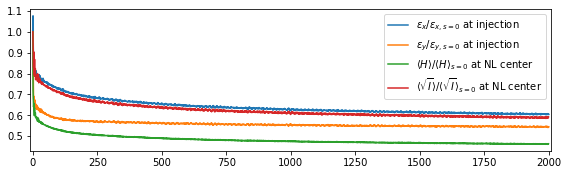

In [85]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

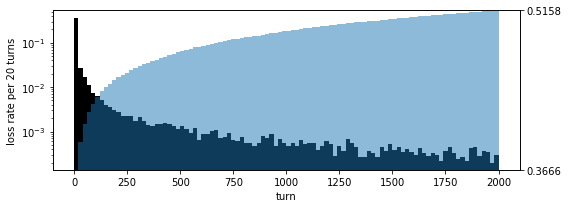

In [86]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

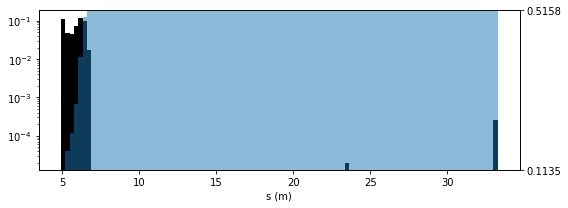

In [87]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [88]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [89]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [90]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData1'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [91]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [92]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

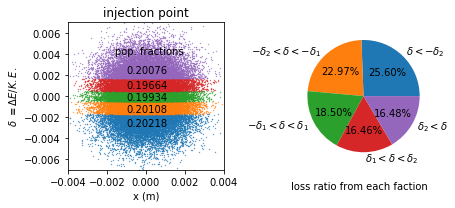

In [93]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,2,figsize=(6.4,3), gridspec_kw={'width_ratios': [1,0.9]})
k=0
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=1
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [94]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

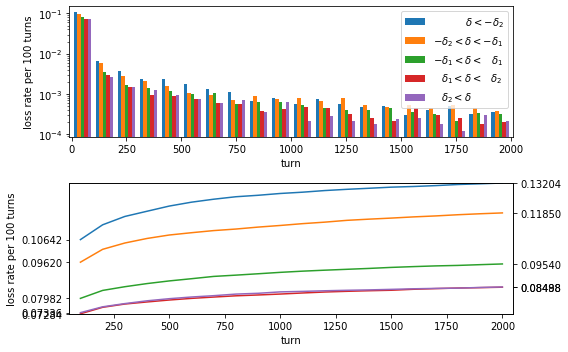

In [95]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [96]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

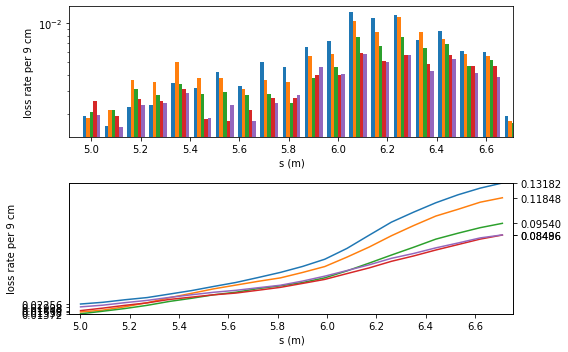

In [97]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, range=(loc_NL+0.045-0.001,loc_NL+1.8+0.045+0.001),
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

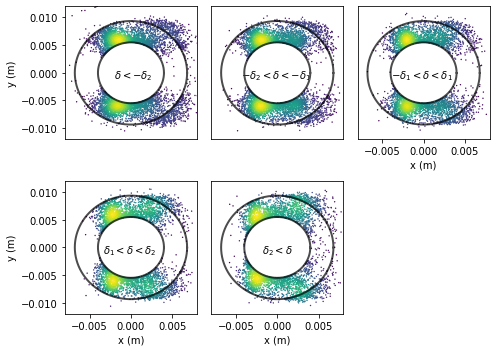

In [98]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [99]:
data['Twiss1']

(0.49414569983363116,
 0.1683315764183921,
 2.6061810960710044e-06,
 2.066065487818308,
 0.46639366775329355,
 5.524515268345755e-06,
 199.47975220151977,
 0.005106741403843367,
 0.005010376903345726)

### SextGoodDA

In [100]:
deco = 'iota_v8_4_SextGoodDA_NLon_exponential'
data = full_data[deco]

In [101]:
data['stat']['emitx'][0],data['stat']['emity'][0],data['stat']['Hmean'][0],data['stat']['Imean'][0]

(1.9037692e-07, 4.0355608e-07, 0.0774740727948, 0.0724770814064)

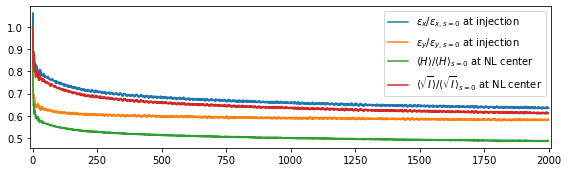

In [102]:
nskip = int(len(data['stat']['s'])/2000)

plt.figure(figsize=(8,2.5))
plt.plot(data['stat']['emitx'][::nskip]/data['stat']['emitx'][0])
plt.plot(data['stat']['emity'][::nskip]/data['stat']['emity'][0])
plt.plot(data['stat']['Hmean']/data['stat']['Hmean'][0])
plt.plot(data['stat']['Imean']/data['stat']['Imean'][0])
plt.legend([r'$\epsilon_x/\epsilon_{x,s=0}$ at injection',
            r'$\epsilon_y/\epsilon_{y,s=0}$ at injection',
            r'$\langle H \rangle/\langle H \rangle_{s=0}$ at NL center',
            r'$\langle \sqrt{I} \rangle/\langle \sqrt{I} \rangle_{s=0}$ at NL center'],
           loc=1)

plt.xlim(-10,2010)
plt.tight_layout()
plt.savefig(deco+'.stat.png',dpi=180)

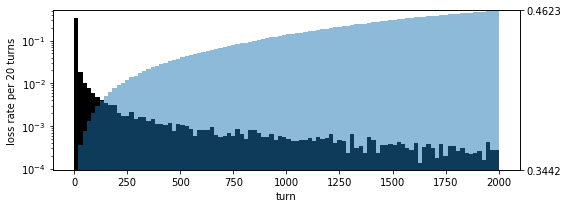

In [103]:
nlost = len(data['pLost'][:,0])

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(data['pLost'][:,0]/L, bins=100, range=(0,nturn))


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 20 turns')
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()
plt.savefig(deco+'.lostHist.png',dpi=180)

<Figure size 576x360 with 0 Axes>

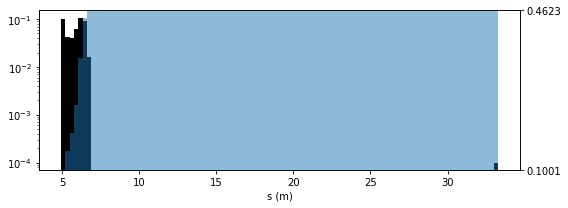

In [104]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8,3))
(counts, bins) = np.histogram(np.mod(data['pLost'][:,0],L), bins=100)


ax1 = plt.hist(bins[:-1], bins, weights = counts/npt, color='k');
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('loss rate per 9 cm');
# plt.xlim(loc_NL,loc_NL+1.8)
ax2 = plt.twinx()
ax2.hist(bins[:-1], bins, weights = counts/npt, cumulative=True, alpha=0.5 );
plt.ylim([counts[0]/npt,np.sum(counts)/npt]);
plt.yticks([counts[0]/npt,np.sum(counts)/npt]);

plt.tight_layout()

In [105]:
from scipy.special import erf

def cdf(x):
    return 0.5*(1.0+erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [106]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [107]:
pDataIndex = [data['pData1'][:,5]/2.5e6 < -X20,
              data['pData1'][:,5]/2.5e6 < -X40,
              data['pData1'][:,5]/2.5e6 <  X40,
              data['pData1'][:,5]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,5]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,5]/2.5e6),
                                X20 <= data['pData1'][:,5]/2.5e6 ]
    
Index = [data['pData1'][pDataIndex[i],-1] for i in range(5)]

pLostIndex = [np.in1d(data['pLost'][:,-1],Index[i]) for i in range(5)]
pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]

In [108]:
# index_Esort = np.argsort(data['pData1'][:,5])
# pDataIndex = [index_Esort[int(0.2*i*npt):int(0.2*(i+1)*npt)] for i in range(5)]

In [109]:
# pLostIndex = [np.in1d(data['pLost'][:,-1],pDataIndex[i]) for i in range(5)]
# pLostEach = [np.sum(pLostIndex[i]) for i in range(5)]
# print(pLostEach)

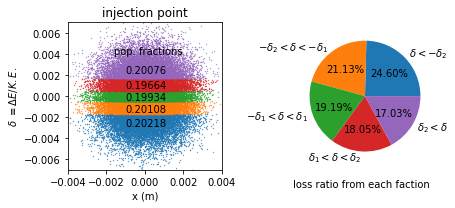

In [110]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
# plt.figure(figsize=(9.5,3))  
f, axs = plt.subplots(1,2,figsize=(6.4,3), gridspec_kw={'width_ratios': [1,0.9]})
k=0
for i in range(5):
    axs[k].scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],5]/2.5e6,s=0.1)
    axs[k].scatter(1,1,color='C'+str(i))
axs[k].set_xlim(-0.004,0.004)
axs[k].set_ylim(-0.007,0.007)
axs[k].text(-0.0016, .004 ,'pop. fractions')
axs[k].text(-0.001, .00217 ,NPT[4]/npt)
axs[k].text(-0.001, .00074 ,NPT[3]/npt);
axs[k].text(-0.001,-.000429,NPT[2]/npt);
axs[k].text(-0.001,-.001548,NPT[1]/npt);
axs[k].text(-0.001,-.00287 ,NPT[0]/npt);
axs[k].set_xlabel('x (m)')
axs[k].set_ylabel(r'$\delta\,\,\equiv \Delta E/K.E.$')
axs[k].set_title('injection point')

k=1
# plt.subplot(1,3,3)
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
axs[k].pie(pLostEach, labels = labels,autopct='%1.2f%%')
axs[k].text(-1.3,-1.65,'loss ratio from each faction')

plt.tight_layout()
plt.savefig(deco+'.popDivOverE.png',dpi=180)

In [111]:
counts, bins, patch = plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
                                bins=20, range=(0,nturn), cumulative=True,
                                weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);
plt.close()

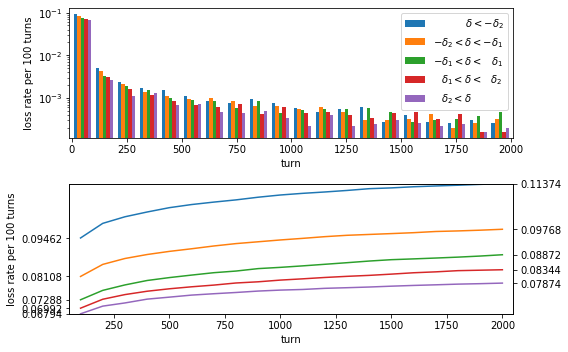

In [112]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)], 
         bins=20, range=(0,nturn), 
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(-10,nturn+10)
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);

ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('turn')
plt.ylabel('loss rate per 100 turns');
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])


ax2 = ax1.twinx()
plt.xlim(50,nturn+50)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overTurns.png',dpi=180)

In [113]:
counts, bins, patch = plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
                                bins=20, range=(loc_NL,loc_NL+1.8), cumulative=True,
                                weights = [np.ones_like(np.mod(data['pLost'][pLostIndex[i],0],L))/npt for i in range(5)]);
plt.close()

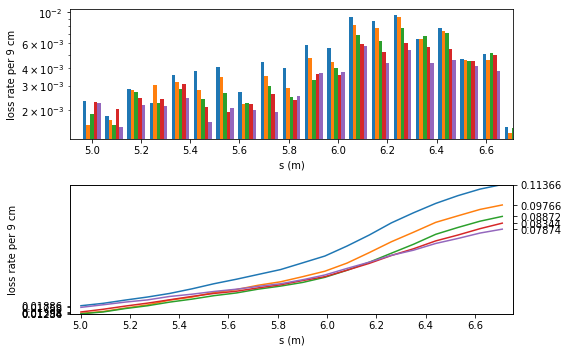

In [114]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)], 
         bins=20, range=(loc_NL+0.045-0.001,loc_NL+1.8+0.045+0.001),
         weights = [np.ones_like(data['pLost'][pLostIndex[i],0])/npt for i in range(5)]);

plt.yscale('log')
plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL,loc_NL+1.8)


ax1 = plt.subplot(2,1,2)
for i in range(5):
    plt.plot(bins[1:],counts[i])

plt.xlabel('s (m)')
plt.ylabel('loss rate per 9 cm');
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][0] for i in range(5)])

ax2 = ax1.twinx()
plt.xlim(loc_NL+0.045,loc_NL+1.8+0.045)
plt.ylim(np.min(np.array(counts)),np.max(np.array(counts)))
plt.yticks([counts[i][-1] for i in range(5)])

plt.tight_layout()
plt.savefig(deco+'.pLoss.eachE.overNL.png',dpi=180)

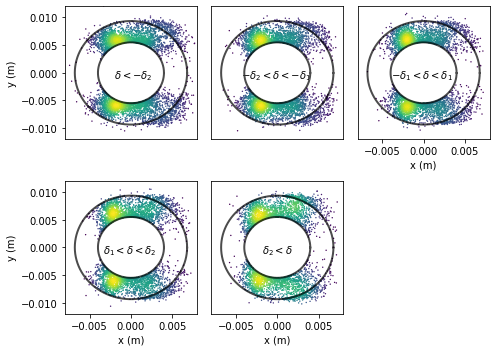

In [115]:
plt.figure(figsize=(7,5))
labels = [r'$ \delta < -\delta_2$',
          r'$-\delta_2 < \delta < -\delta_1$',
          r'$-\delta_1 < \delta < \delta_1$',
          r'$ \delta_1 < \delta < \delta_2$',
          r'$\delta_2 < \delta$']
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
    # plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='C0')
    impact.plot.density(data['pLost'][pLostIndex[i],1],data['pLost'][pLostIndex[i],2],mksize=2.0)
    
    if i<2:
        plt.xticks([])
    else:
        plt.xticks([-0.005,0,0.005])
        plt.xlabel('x (m)')
    if i in [1,2,4]:
        plt.yticks([])
    else:
        plt.ylabel('y (m)')
        
    plt.xlim(-0.008,0.008)
    plt.ylim(-0.012,0.012)
    if i==0:
        plt.text(-0.0021,-0.001,labels[i])
    if i==1:
        plt.text(-0.00435,-0.001,labels[i],color='w')
        plt.text(-0.00445,-0.001,labels[i],color='w')
        plt.text(-0.0044,-0.001,labels[i])
    if i==2:
        plt.text(-0.0040,-0.001,labels[i])
    if i==3:
        plt.text(-0.0034,-0.001,labels[i])
    if i==4:
        plt.text(-0.0018,-0.001,labels[i])

plt.tight_layout()
plt.savefig(deco+'.pLossXY.eachE.png',dpi=180)

In [116]:
data['Twiss1']

(0.49414569983363116,
 0.1683315764183921,
 2.6061810960710044e-06,
 2.066065487818308,
 0.46639366775329355,
 5.524515268345755e-06,
 199.47975220151977,
 0.005106741403843367,
 0.005010376903345726)